In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

plt.rcParams["figure.figsize"] = (10, 5)

BASE_DIR = Path.cwd().parents[0]  # notebooks/ -> project root
CLEAN_PATH = BASE_DIR / "data" / "cleaned" / "nyc_311_full_year_cleaned.parquet"

CLEAN_PATH, CLEAN_PATH.exists()

(PosixPath('/Users/yerapark/Documents/GitHub/nyc-311-service-analysis/data/cleaned/nyc_311_full_year_cleaned.parquet'),
 True)

In [8]:
df = pd.read_parquet(CLEAN_PATH)
df.shape, df.dtypes.head(15)

((3207336, 14),
 created_date        datetime64[ns]
 closed_date         datetime64[ns]
 complaint_type              object
 descriptor                  object
 agency                      object
 borough                     object
 incident_zip                object
 latitude                    object
 longitude                   object
 resolution_hours           float32
 month                      float32
 hour                       float32
 weekday                    float32
 is_weekend                 float32
 dtype: object)

In [9]:
df["resolution_hours"].describe()
df["complaint_type"].value_counts().head(10)
df["agency"].value_counts().head(10)
df["borough"].value_counts()

borough
BROOKLYN         949794
QUEENS           775941
BRONX            747243
MANHATTAN        612980
STATEN ISLAND    119695
Unspecified        1683
Name: count, dtype: int64

In [10]:
# Focus on more frequent complaint types and agencies
top_complaints = df["complaint_type"].value_counts().head(30).index
top_agencies = df["agency"].value_counts().head(20).index

df_model = df[
    df["complaint_type"].isin(top_complaints)
    & df["agency"].isin(top_agencies)
].copy()

df_model.shape

(2725841, 14)

In [11]:
n_sample = min(300_000, len(df_model))
df_sample = df_model.sample(n=n_sample, random_state=42)

df_sample.shape

(300000, 14)

In [12]:
target_col = "resolution_hours"

feature_cols = [
    "complaint_type",
    "borough",
    "agency",
    "month",
    "hour",
    "weekday",
    "is_weekend",
]

df_sample = df_sample.dropna(subset=feature_cols + [target_col]).copy()

X_raw = df_sample[feature_cols]
y = df_sample[target_col]

X_raw.head()

,complaint_type,borough,agency,month,hour,weekday,is_weekend
33746,Illegal Parking,QUEENS,NYPD,12.0,22.0,0.0,0.0
2096744,Water System,BROOKLYN,DEP,8.0,17.0,3.0,0.0
1627346,Water System,QUEENS,DEP,7.0,7.0,1.0,0.0
992057,Water System,BROOKLYN,DEP,4.0,14.0,4.0,0.0
995086,Noise - Residential,BRONX,NYPD,4.0,21.0,4.0,0.0


In [13]:
categorical_cols = ["complaint_type", "borough", "agency"]
numeric_cols = ["month", "hour", "weekday", "is_weekend"]

X_categorical = pd.get_dummies(X_raw[categorical_cols], drop_first=True)
X_numeric = X_raw[numeric_cols]

X = pd.concat([X_numeric, X_categorical], axis=1)

X.shape, y.shape

((300000, 45), (300000,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((240000, 45), (60000, 45))

In [15]:
baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)

y_pred_base = baseline.predict(X_test)
base_mae = mean_absolute_error(y_test, y_pred_base)
base_r2 = r2_score(y_test, y_pred_base)

base_mae, base_r2

(45.65310287475586, -1.0848045349121094e-05)

In [16]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lr = linreg.predict(X_test)

lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

lr_mae, lr_r2

(29.285240173339844, 0.36237579584121704)

In [17]:
rf = RandomForestRegressor(
    n_estimators=150,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

rf_mae, rf_r2

(26.10200045499179, 0.34972124191052667)

In [18]:
results = pd.DataFrame({
    "model": ["Baseline (mean)", "Linear Regression", "Random Forest"],
    "MAE": [base_mae, lr_mae, rf_mae],
    "R2": [base_r2, lr_r2, rf_r2],
})

results

,model,MAE,R2
0,Baseline (mean),45.653103,-0.000011
1,Linear Regression,29.285240,0.362376
2,Random Forest,26.102000,0.349721


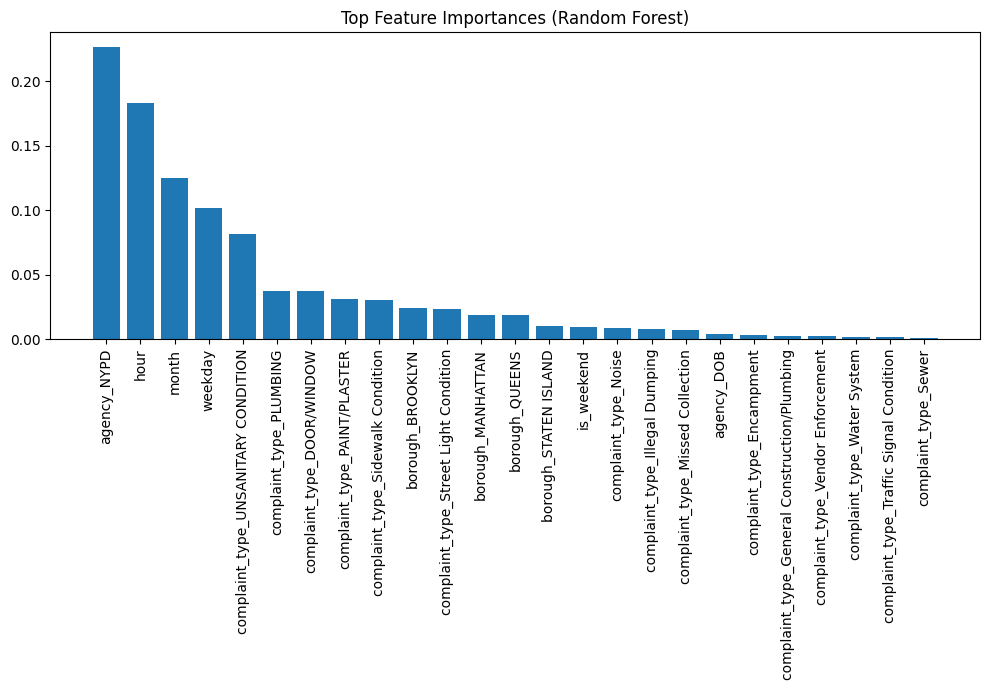

In [19]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

top_n = 25
top_idx = indices[:top_n]

plt.figure(figsize=(10, 7))
plt.bar(range(top_n), importances[top_idx])
plt.xticks(range(top_n), feature_names[top_idx], rotation=90)
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

In [20]:
import joblib, json

MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)

joblib.dump(rf, MODELS_DIR / "rf_full_year_resolution_time.joblib")

metrics = {
    "baseline": {"MAE": float(base_mae), "R2": float(base_r2)},
    "linear_regression": {"MAE": float(lr_mae), "R2": float(lr_r2)},
    "random_forest": {"MAE": float(rf_mae), "R2": float(rf_r2)},
}

with open(MODELS_DIR / "full_year_model_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

MODELS_DIR

PosixPath('/Users/yerapark/Documents/GitHub/nyc-311-service-analysis/models')